# Predicción del precio de Bitcoin
### Proyecto individual de Machine Learning

## Propósito del proyecto

Ahora está muy de moda todo el tema de las criptomonedas. Si bien ya existen desde hace unos años, su evolución y la facilidad de acceso a los pequeños y medianos inversores, han hecho que haya un *boom* en la apuesta por esta forma de dinero.

Antes de nada, hay que saber que toda inversión a corto, medio o largo plazo supone un riesgo. Un riesgo que aumenta considerablemente en las criptomonedas frente a otro tipo de divisas FIAT (o acciones en bolsa). Esto es debido a su alta volatilidad. Mientras que en la bolsa común se manejan aumentos o descensos diarios de menos del 1% (normalmente), en el mercado cripto las variaciones diarias están muy por encima de ese porcentaje. Aunque lo común es ver variaciones entre el 1 y el 5% diarias, pueden haber picos de hasta un 20% o 40% diarios. Ni que decir tiene que es un altísimo riesgo del capital invertido. Se puede ganar mucho, pero también se puede perder mucho.

Por tanto, quiero aclarar que este proyecto no es, ni mucho menos, una herramienta fiable para invertir eficazmente en este mercado. Más bien es un proyecto con fines didácticos y de ejemplo de cómo usar el aprendizaje automático para hacer una aproximación predictora del precio futuro. Evidentemente entran en juego muchos factores humanos que no se tienen en cuenta en este proyecto debido a que son difícilmente cuantificables y predecibles. El simple hecho de que un día, una gran empresa como Amazon, permita comprar sus productos con bitcoins, daría un impulso a su precio. O basta un tweet negativo de Elon Mask (como ya vimos), para hacer caer el precio casi un 40%. Además es un mercado que está bastante influenciado por el **FOMO** (*fear of missing out*) y, por tanto, también depende mucho de las sensaciones de los inversores.

Después de esta aclaración, el propósito del proyecto no es más que aplicar varios conceptos de Machine Learning a un tema tan actual para intentar acercarse a una predicción del precio de Bitcoin.

## Los datos

El set de datos ha sido obtenido en la web de [(Yahoo Finance)](https://es.finance.yahoo.com/quote/BTC-USD/history?p=BTC-USD) y puede ser descargado.


Los datos están concentrados en un archivo *.csv* en la carpeta **data**:

- Contiene 7 columnas (Fecha, Apertura, Máximo, Mínimo, Cierre, Cierre ajustado y Volumen) y 2579 filas (una para cada fecha).

- Descripción de las columnas:
    
    - **Fecha:** Desde el 17/09/2014 hasta hoy (diario).
    - **Apertura:** Precio con el que se inicia la jornada.
    - **Máximo:** Precio más alto que se alcanzó en esa jornada.
    - **Mínimo:** Precio más bajo que se alcanzó en esa jornada.
    - **Cierre:** Precio con el que se termina la jornada.
    - **Cierre ajustado:** El cierre ajustado es el precio de cierre después de los ajustes para todas las distribuciones de splits y dividendos aplicables.
    - **Volumen:** El volumen es la cantidad de un activo concreto en el que se invierte durante un período de tiempo determinado.
        

En total, el dataset se compone de 18053 datos.

### Librerías, módulos y ajustes necesarios para el análisis

In [2]:
# Librerías
import pandas as pd
import numpy as np
import pandas as pd
import requests
import sys
import os
import time
import matplotlib.pyplot as plt
from sklearn import metrics
from keras.layers.core import Dense, Activation, Dropout
from sklearn import preprocessing
from keras import optimizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from keras.layers import Dropout, Flatten, Embedding
from keras.layers import Conv2D, MaxPooling2D
import keras
from keras.preprocessing import sequence
from keras.layers import LSTM

# PATHS
SEP = os.sep
sys.path.append(os.path.dirname(os.getcwd()) + SEP + 'src' + SEP + 'utils')
sys.path.append(os.path.dirname(os.getcwd()) + SEP + 'resources')
ruta_train = os.path.dirname(os.getcwd()) + SEP + 'data' + SEP + 'entrenamiento'
ruta_test = os.path.dirname(os.getcwd()) + SEP + 'data' + SEP + 'testeo'
guardar_modelo = os.path.dirname(os.getcwd()) + SEP + 'models' + SEP

# Módulos propios
import mining_data_tb as mdtb
import visualization_tb as vtb
import folders_tb as ftb
import models as m

## Data mining & Data wrangling

Como observamos a continuación, vemos un DataFrame de Pandas con su índice númerico y las 7 columnas. Para este estudio, nuestro **target** será la columna *Close* que, más adelante pasará a llamarse *cierre* y que corresponde al precio objetivo de cierre.

In [2]:
btc = pd.read_csv(ruta_train + SEP + 'BTC-USD.csv')
btc.head()

Date        Open        High         Low       Close   Adj Close  \
0  2014-09-17  465.864014  468.174011  452.421997  457.334015  457.334015   
1  2014-09-18  456.859985  456.859985  413.104004  424.440002  424.440002   
2  2014-09-19  424.102997  427.834991  384.532013  394.795990  394.795990   
3  2014-09-20  394.673004  423.295990  389.882996  408.903992  408.903992   
4  2014-09-21  408.084991  412.425995  393.181000  398.821014  398.821014   

       Volume  
0  21056800.0  
1  34483200.0  
2  37919700.0  
3  36863600.0  
4  26580100.0

In [3]:
btc_para_testeo = pd.read_csv(ruta_test + SEP + 'btc_test.csv')
btc_para_testeo

Date          Open          High           Low         Close  \
0  2021-07-01  35035.984375  35035.984375  32883.781250  33572.117188   
1  2021-07-02  33549.601563  33939.589844  32770.679688  33897.046875   
2  2021-07-03  33854.421875  34909.261719  33402.695313  34668.546875   
3  2021-07-04  34665.566406  35937.566406  34396.476563  35287.781250   
4  2021-07-05  35284.343750  35284.343750  33213.660156  33746.003906   
5  2021-07-06  33763.742188  35038.535156  33759.960938  33897.316406   

      Adj Close       Volume  
0  33572.117188  37838957079  
1  33897.046875  38728974942  
2  34668.546875  24383958643  
3  35287.781250  24924307911  
4  33746.003906  26721554282  
5  33897.316406  25984114688

Realizamos un análisis preeliminar de los datos:

Podemos ver que se compone de:
- 2479 filas
- 7 columnas

Tenemos seis columnas de tipo float64 y una de tipo object. También vemos una breve descripción estadística de los datos y que en todas las columnas (excepto la de fecha), existen 4 valores NaN

In [4]:
mdtb.analisis_df(btc)

-----------------------# FILAS Y COLUMNAS #-------------------------
Cantidad de filas: 2479 
Cantidad de columnas: 7

----------------------# INFORMACIÓN GENERAL #-----------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2479 entries, 0 to 2478
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2479 non-null   object 
 1   Open       2475 non-null   float64
 2   High       2475 non-null   float64
 3   Low        2475 non-null   float64
 4   Close      2475 non-null   float64
 5   Adj Close  2475 non-null   float64
 6   Volume     2475 non-null   float64
dtypes: float64(6), object(1)
memory usage: 135.7+ KB
None

-------------------# DESCRIPCIÓN ESTADÍSTICA #----------------------
               Open          High           Low         Close     Adj Close  \
count   2475.000000   2475.000000   2475.000000   2475.000000   2475.000000   
mean    7909.378114   8137.427130   7656.672479   7922.1840

Cambiamos ahora los nombres de las columnas para que estén en español.

In [5]:
mdtb.nombres_columnas(btc)

Las columnas actuales son: Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
------------------------------------------------
Las nuevas columnas son: Index(['fecha', 'apertura', 'maximo', 'minimo', 'cierre', 'cierre_ajustado',
       'volumen'],
      dtype='object')


fecha      apertura        maximo        minimo        cierre  \
0     2014-09-17    465.864014    468.174011    452.421997    457.334015   
1     2014-09-18    456.859985    456.859985    413.104004    424.440002   
2     2014-09-19    424.102997    427.834991    384.532013    394.795990   
3     2014-09-20    394.673004    423.295990    389.882996    408.903992   
4     2014-09-21    408.084991    412.425995    393.181000    398.821014   
...          ...           ...           ...           ...           ...   
2474  2021-06-26  31594.664063  32637.587891  30184.501953  32186.277344   
2475  2021-06-27  32287.523438  34656.128906  32071.757813  34649.644531   
2476  2021-06-28  34679.121094  35219.890625  33902.074219  34434.335938   
2477  2021-06-29  34475.558594  36542.109375  34252.484375  35867.777344   
2478  2021-06-30  35852.679688  36074.757813  34527.535156  34864.378906   

      cierre_ajustado       volumen  
0          457.334015  2.105680e+07  
1          424.440002  3.448320e+07  
2          394.795990  3.791970e+07  
3          408.903992  3.686360e+07  
4          398.821014  2.658010e+07  
...               ...           ...  
2474     32186.277344  3.858539e+10  
2475     34649.644531  3.551164e+10  
2476     34434.335938  3.389252e+10  
2477     35867.777344  3.790146e+10  
2478     34864.378906  3.516495e+10  

[2479 rows x 7 columns]

Una vez hecho esto, decido eliminar del dataframe original la columna de cierre_ajustado ya que en el caso de BTC no aporta valor. Y la columna de fecha queda eliminada porque los datos están correctamente ordenados.

## VISUALIZACIÓN

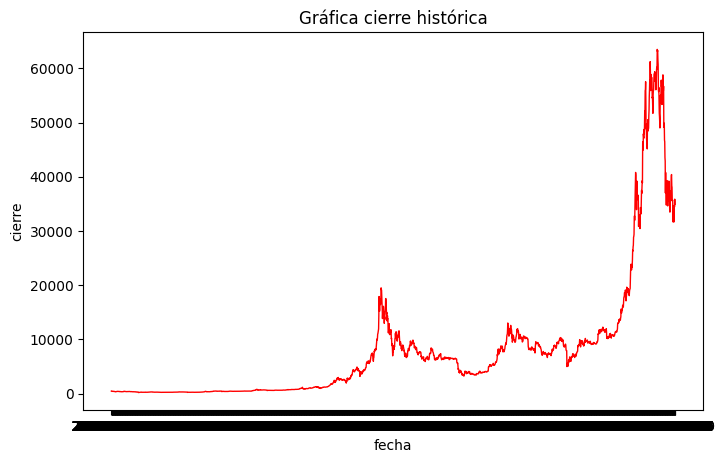

In [6]:
vtb.grafica('lineplot', btc, 'fecha', 'cierre', 'Gráfica cierre histórica');
ftb.guardar_grafico('cierre.jpg')

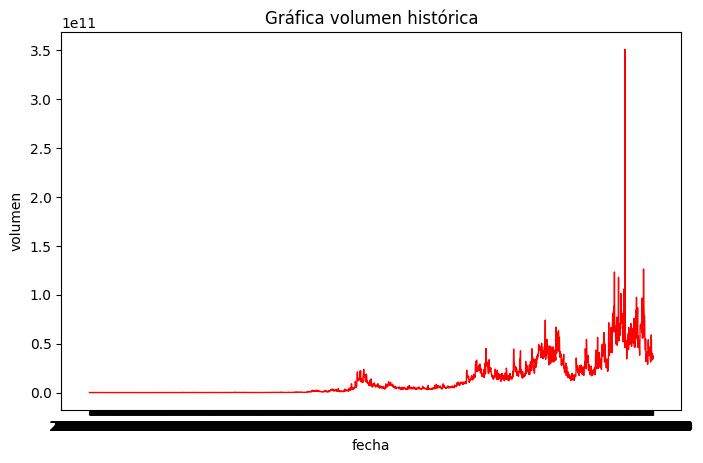

In [7]:
vtb.grafica('lineplot', btc, 'fecha', 'volumen', 'Gráfica volumen histórica');
ftb.guardar_grafico('volumen.jpg')

In [8]:
vtb.grafica_interactiva('scatter', btc, 'fecha', 'cierre', 'Precio BTC')

In [9]:
mdtb.eliminar_columnas(btc, 'cierre_ajustado')
mdtb.eliminar_columnas(btc, 'fecha')

######## ATENCIÓN ########
La columna "cierre_ajustado" ha sido eliminada del DataFrame
######## ATENCIÓN ########
La columna "fecha" ha sido eliminada del DataFrame


apertura        maximo        minimo        cierre       volumen
0       465.864014    468.174011    452.421997    457.334015  2.105680e+07
1       456.859985    456.859985    413.104004    424.440002  3.448320e+07
2       424.102997    427.834991    384.532013    394.795990  3.791970e+07
3       394.673004    423.295990    389.882996    408.903992  3.686360e+07
4       408.084991    412.425995    393.181000    398.821014  2.658010e+07
...            ...           ...           ...           ...           ...
2474  31594.664063  32637.587891  30184.501953  32186.277344  3.858539e+10
2475  32287.523438  34656.128906  32071.757813  34649.644531  3.551164e+10
2476  34679.121094  35219.890625  33902.074219  34434.335938  3.389252e+10
2477  34475.558594  36542.109375  34252.484375  35867.777344  3.790146e+10
2478  35852.679688  36074.757813  34527.535156  34864.378906  3.516495e+10

[2479 rows x 5 columns]

Con estas sencillas lineas de código, contamos los valores NaN que hay en cada columna, los borramos y comprobamos que hayan sido eliminados correctamente.

In [10]:
print("Valores NaN en la columna de apertura",btc.isna().sum()['apertura'])
print("Valores NaN en la columna de maximo",btc.isna().sum()['maximo'])
print("Valores NaN en la columna de minimo",btc.isna().sum()['minimo'])
print("Valores NaN en la columna de cierre",btc.isna().sum()['cierre'])
print("Valores NaN en la columna de volumen",btc.isna().sum()['volumen'])

Valores NaN en la columna de apertura 4
Valores NaN en la columna de maximo 4
Valores NaN en la columna de minimo 4
Valores NaN en la columna de cierre 4
Valores NaN en la columna de volumen 4


In [11]:
btc = btc.dropna(how='any',axis=0)

In [12]:
print("Valores NaN en la columna de apertura",btc.isna().sum()['apertura'])
print("Valores NaN en la columna de maximo",btc.isna().sum()['maximo'])
print("Valores NaN en la columna de minimo",btc.isna().sum()['minimo'])
print("Valores NaN en la columna de cierre",btc.isna().sum()['cierre'])
print("Valores NaN en la columna de volumen",btc.isna().sum()['volumen'])

Valores NaN en la columna de apertura 0
Valores NaN en la columna de maximo 0
Valores NaN en la columna de minimo 0
Valores NaN en la columna de cierre 0
Valores NaN en la columna de volumen 0


## PREPROCESAMIENTO DE LOS DATOS

Ahora pasamos a normalizar las columnas (excepto la de 'cierre'). El objetivo de la **normalización** es cambiar los valores de las columnas numéricas del conjunto de datos para usar una escala común, sin distorsionar las diferencias en los intervalos de valores ni perder información. La normalización también es necesaria para que algunos algoritmos modelen los datos correctamente.

In [13]:
mdtb.normalizar(btc, 'apertura')
mdtb.normalizar(btc, 'maximo')
mdtb.normalizar(btc, 'minimo')
mdtb.normalizar(btc, 'volumen')

c:\Users\iafp6\OneDrive\Escritorio\bitcoin\src\utils\mining_data_tb.py:44: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [14]:
btc

apertura    maximo    minimo        cierre   volumen
0     0.004562  0.003967  0.004528    457.334015  0.000043
1     0.004420  0.003792  0.003894    424.440002  0.000081
2     0.003902  0.003343  0.003434    394.795990  0.000091
3     0.003438  0.003272  0.003520    408.903992  0.000088
4     0.003650  0.003104  0.003573    398.821014  0.000059
...        ...       ...       ...           ...       ...
2474  0.495964  0.501549  0.483788  32186.277344  0.109925
2475  0.506902  0.532771  0.514209  34649.644531  0.101167
2476  0.544656  0.541491  0.543713  34434.335938  0.096553
2477  0.541442  0.561943  0.549361  35867.777344  0.107976
2478  0.563182  0.554714  0.553795  34864.378906  0.100179

[2475 rows x 5 columns]

Con una sencilla función, vamos a convertir los datos para entrenar el modelo y los datos objetivo en arrays de NumPy.

In [15]:
x,y = m.xy(btc, 'cierre')

Una vez hecho todo lo anterior, procedemos a dividir los datos en los conjuntos de entrenamiento y de test. Por supuesto, cada conjunto tendrá sus variables *X* y su variable objetivo *y*.

He querido dividir los datos con un 20% para el conjunto de test y el resto para el de entrenamiento.

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=45)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((1980, 4), (495, 4), (1980,), (495,))

## PRUEBA DE MODELOS

En esta sección experimentaremos sobre algunos modelos de ML más avanzados para entrenar nuestro conjunto de datos y poder ver los resultados obtenidos, comparándolos con los datos reales.
Cada modelo se entrenará varias veces, con épocas diferentes y cambiando algunos parámetros como el modo de activación, el dropout y el optimizador. Añadiremos un EarlingStopping para evitar el sobreentrenamiento.

Para saber bien lo que se está haciendo, se ha consultado la documentación de [Keras](https://keras.io/api/) y así poder ver qué parámetros se pueden modificar.

Además, se guardarán los mejores pesos de cada modelo en un archivo. El formato de ese archivo será `.hdf5` ya que es bueno para almacenar grandes datos numéricos.

Primero importamos algunas librerías necesarias de Keras que no se importaron al principio.

In [17]:
from keras.models import Sequential
from keras.layers.core import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint

### MODELO 1

Probamos primero una red neuronal con un modo de activación Relu, optimizador ADAM y dos capas ocultas: la primera de 50 neuronas y la segunda de 25. Una capa de salida con una neurona y un entrenamiento de 1000 épocas.

In [18]:
checkpointer = ModelCheckpoint(filepath=guardar_modelo + "mejores_pesos_adam_relu.hdf5", verbose=0, save_best_only=True)
modelo_adam_relu = Sequential()
modelo_adam_relu.add(Dense(50, input_dim=x_train.shape[1], activation='relu'))
modelo_adam_relu.add(Dense(25, activation='relu'))
modelo_adam_relu.add(Dense(1))
modelo_adam_relu.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')

modelo_adam_relu.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                250       
_________________________________________________________________
dense_1 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 26        
Total params: 1,551
Trainable params: 1,551
Non-trainable params: 0
_________________________________________________________________


Después de visualizar el resumen del modelo, pasamos a entrenarlo.

In [19]:
start_time = time.time()
for i in range(5):
    modelo_adam_relu.fit(x_train,y_train, validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=1000)
modelo_adam_relu.load_weights(guardar_modelo + 'mejores_pesos_adam_relu.hdf5')

tiempo_procesamiento = time.time() - start_time
print("Tiempo de procesamiento: {}".format(tiempo_procesamiento))

Epoch 1/1000
62/62 - 9s - loss: 203211024.0000 - val_loss: 214680912.0000
Epoch 2/1000
62/62 - 0s - loss: 203168848.0000 - val_loss: 214599472.0000
Epoch 3/1000
62/62 - 0s - loss: 203034736.0000 - val_loss: 214388848.0000
Epoch 4/1000
62/62 - 0s - loss: 202738048.0000 - val_loss: 213974224.0000
Epoch 5/1000
62/62 - 0s - loss: 202219344.0000 - val_loss: 213300528.0000
Epoch 6/1000
62/62 - 0s - loss: 201438960.0000 - val_loss: 212306496.0000
Epoch 7/1000
62/62 - 0s - loss: 200315312.0000 - val_loss: 210946864.0000
Epoch 8/1000
62/62 - 0s - loss: 198803120.0000 - val_loss: 209162000.0000
Epoch 9/1000
62/62 - 0s - loss: 196854560.0000 - val_loss: 206863824.0000
Epoch 10/1000
62/62 - 0s - loss: 194392672.0000 - val_loss: 204030496.0000
Epoch 11/1000
62/62 - 0s - loss: 191402144.0000 - val_loss: 200606880.0000
Epoch 12/1000
62/62 - 0s - loss: 187892240.0000 - val_loss: 196651536.0000
Epoch 13/1000
62/62 - 0s - loss: 183858560.0000 - val_loss: 192170288.0000
Epoch 14/1000
62/62 - 0s - loss: 1

Visualizamos, a continuación, la gráfica comparativa de los datos reales y de las predicciones a lo largo del tiempo. Y podemos ver que este modelo tiene bastante tasa de acierto. **Consigue un R2 de 0.9988 y un RMSE de 412.26 aproximadamente**.

Shape: (495, 1)
Puntuación final (RMSE): 408.97467041015625
Puntuación R cuadrática: 0.998884


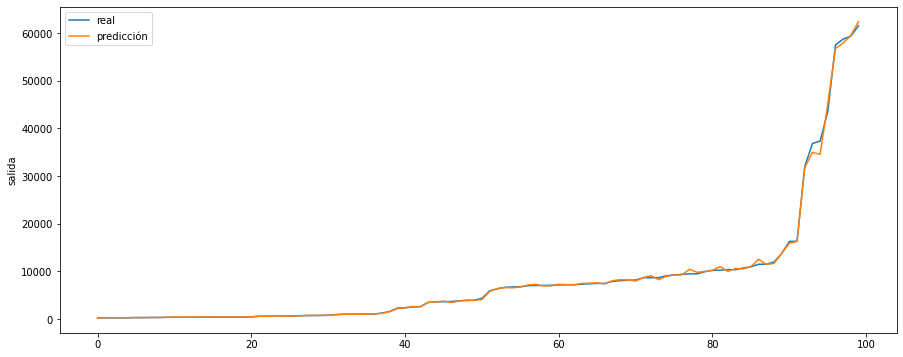

<Figure size 432x288 with 0 Axes>

In [20]:
vtb.visualizar_modelo(modelo_adam_relu, x_test, y_test)
ftb.guardar_grafico('modelo_adam_relu.jpg')

### MODELO 2

Probamos después una red neuronal con un modo de activación Relu, optimizador rmsprop y dos capas ocultas: la primera de 50 neuronas y la segunda de 25. Una capa de salida con una neurona y un entrenamiento de 1000 épocas.

In [21]:
checkpointer = ModelCheckpoint(filepath=guardar_modelo + "mejores_pesos_rmsprop_relu.hdf5", verbose=0, save_best_only=True)
modelo_rmsprop_relu = Sequential()
modelo_rmsprop_relu.add(Dense(50, input_dim=x_train.shape[1], activation='relu'))
modelo_rmsprop_relu.add(Dense(25, activation='relu'))
modelo_rmsprop_relu.add(Dense(1))
modelo_rmsprop_relu.compile(loss='mean_squared_error', optimizer='rmsprop')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
modelo_rmsprop_relu.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 50)                250       
_________________________________________________________________
dense_4 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 26        
Total params: 1,551
Trainable params: 1,551
Non-trainable params: 0
_________________________________________________________________


Después de visualizar el resumen del modelo, pasamos a entrenarlo.

In [22]:
start_time = time.time()
for i in range(5):
    print(i)
    modelo_rmsprop_relu.fit(x_train,y_train, validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=1000)
modelo_rmsprop_relu.load_weights(guardar_modelo + 'mejores_pesos_rmsprop_relu.hdf5')

tiempo_procesamiento = time.time() - start_time
print("Tiempo de procesamiento: {}".format(tiempo_procesamiento))

0
Epoch 1/1000
62/62 - 1s - loss: 203205264.0000 - val_loss: 214670448.0000
Epoch 2/1000
62/62 - 0s - loss: 203161232.0000 - val_loss: 214605536.0000
Epoch 3/1000
62/62 - 0s - loss: 203080640.0000 - val_loss: 214500352.0000
Epoch 4/1000
62/62 - 0s - loss: 202954640.0000 - val_loss: 214340720.0000
Epoch 5/1000
62/62 - 0s - loss: 202766032.0000 - val_loss: 214107776.0000
Epoch 6/1000
62/62 - 0s - loss: 202500000.0000 - val_loss: 213782208.0000
Epoch 7/1000
62/62 - 0s - loss: 202149552.0000 - val_loss: 213377680.0000
Epoch 8/1000
62/62 - 0s - loss: 201723984.0000 - val_loss: 212874096.0000
Epoch 9/1000
62/62 - 0s - loss: 201184016.0000 - val_loss: 212253408.0000
Epoch 10/1000
62/62 - 0s - loss: 200522336.0000 - val_loss: 211504272.0000
Epoch 11/1000
62/62 - 0s - loss: 199736640.0000 - val_loss: 210610640.0000
Epoch 12/1000
62/62 - 0s - loss: 198792144.0000 - val_loss: 209543280.0000
Epoch 13/1000
62/62 - 0s - loss: 197737536.0000 - val_loss: 208353840.0000
Epoch 14/1000
62/62 - 0s - loss:

Visualizamos, a continuación, la gráfica comparativa de los datos reales y de las predicciones a lo largo del tiempo. Y podemos ver que este modelo tiene bastante tasa de acierto. **Consigue un R2 de 0.9988 y un RMSE de 409.29 aproximadamente**.

Shape: (495, 1)
Puntuación final (RMSE): 410.0688781738281
Puntuación R cuadrática: 0.998878


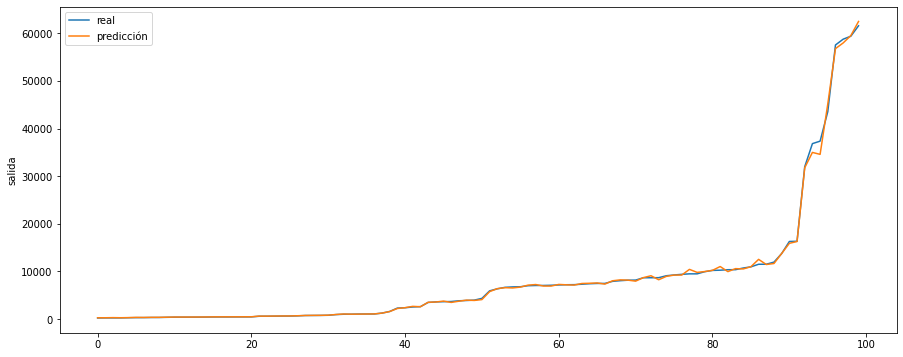

<Figure size 432x288 with 0 Axes>

In [23]:
vtb.visualizar_modelo(modelo_rmsprop_relu, x_test, y_test)
ftb.guardar_grafico('modelo_rmsprop_relu.jpg')

Ahora usaremos la RNN de tipo LSTM para ver si mejoran los resultados.

In [24]:
btc.head()

apertura    maximo    minimo      cierre   volumen
0  0.004562  0.003967  0.004528  457.334015  0.000043
1  0.004420  0.003792  0.003894  424.440002  0.000081
2  0.003902  0.003343  0.003434  394.795990  0.000091
3  0.003438  0.003272  0.003520  408.903992  0.000088
4  0.003650  0.003104  0.003573  398.821014  0.000059

Ahora sí, probaremos a normalizar la columna *cierre*, y ver si afecta positiva o negativamente a nuestros resultados.

In [25]:
btc_cierre = btc['cierre'].tolist()

In [26]:
mdtb.normalizar(btc, 'cierre')

c:\Users\iafp6\OneDrive\Escritorio\bitcoin\src\utils\mining_data_tb.py:44: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [27]:
btc.head()

apertura    maximo    minimo    cierre   volumen
0  0.004562  0.003967  0.004528  0.004409  0.000043
1  0.004420  0.003792  0.003894  0.003890  0.000081
2  0.003902  0.003343  0.003434  0.003422  0.000091
3  0.003438  0.003272  0.003520  0.003645  0.000088
4  0.003650  0.003104  0.003573  0.003485  0.000059

Para poder obtener buenos resultados, debemos secuenciar los datos para que vayan ordenados y los entrene a lo largo del tiempo. Para ello, he decidido darle una secuencia equivalente a 7.

Luego dividimos los datos, como antes, en los conjuntos de train y de test, con un 20% para el conjunto de test.

In [28]:
x_lstm, y_lstm = m.secuenciar(secuencia=7, df=btc.values, data=btc_cierre)
print("Shape de x: {}".format(x_lstm.shape))
print("Shape de y: {}".format(y_lstm.shape))

Shape de x: (2467, 7, 5)
Shape de y: (2467,)


In [29]:
x_train_lstm, x_test_lstm, y_train_lstm, y_test_lstm = train_test_split(x_lstm,y_lstm, test_size=0.2, random_state =42)
print("Shape de x_train: {}".format(x_train_lstm.shape))
print("Shape de x_test: {}".format(x_test_lstm.shape))
print("Shape de y_train: {}".format(y_train_lstm.shape))
print("Shape de y_test: {}".format(y_test_lstm.shape))

Shape de x_train: (1973, 7, 5)
Shape de x_test: (494, 7, 5)
Shape de y_train: (1973,)
Shape de y_test: (494,)


### MODELO 3

Probamos ahora una red neuronal recurrente LSTM con un optimizador adam y dos capas: la primera LSTM de 100 neuronas y la segunda Dense de 50, sin dropout. Una capa de salida con una neurona y un entrenamiento de 10 épocas. Siempre suelo ponerle `patience=5`, lo que significa que debe de esperar al menos 5 épocas sin que haya mejoras para activar el EarlyStopping.

In [30]:
checkpointer = ModelCheckpoint(filepath=guardar_modelo + "mejores_pesos_lstm_sinDO.hdf5", verbose=0, save_best_only=True)
model_lstm_sin = Sequential()
model_lstm_sin.add(LSTM(100, dropout=0.1, recurrent_dropout=0.1, input_shape=(7, 5)))
model_lstm_sin.add(Dense(50))
model_lstm_sin.add(Dense(1))
model_lstm_sin.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
model_lstm_sin.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               42400     
_________________________________________________________________
dense_6 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 51        
Total params: 47,501
Trainable params: 47,501
Non-trainable params: 0
_________________________________________________________________


In [31]:
start_time = time.time()
for i in range(5):
    print(i)    
    model_lstm_sin.fit(x_train_lstm,y_train_lstm,validation_data=(x_test_lstm,y_test_lstm),callbacks=[monitor, checkpointer],verbose=2, epochs=10)
model_lstm_sin.load_weights(guardar_modelo + 'mejores_pesos_lstm_sinDO.hdf5')

tiempo_procesamiento = time.time() - start_time
print("Tiempo de procesamiento: {}".format(tiempo_procesamiento))

0
Epoch 1/10
62/62 - 8s - loss: 209731984.0000 - val_loss: 186425136.0000
Epoch 2/10
62/62 - 0s - loss: 207513904.0000 - val_loss: 183834256.0000
Epoch 3/10
62/62 - 0s - loss: 204192144.0000 - val_loss: 180201984.0000
Epoch 4/10
62/62 - 0s - loss: 199774464.0000 - val_loss: 175586624.0000
Epoch 5/10
62/62 - 0s - loss: 194434128.0000 - val_loss: 170291872.0000
Epoch 6/10
62/62 - 0s - loss: 188412480.0000 - val_loss: 164616352.0000
Epoch 7/10
62/62 - 0s - loss: 182122656.0000 - val_loss: 158728896.0000
Epoch 8/10
62/62 - 0s - loss: 175875440.0000 - val_loss: 153254944.0000
Epoch 9/10
62/62 - 0s - loss: 169965904.0000 - val_loss: 148175712.0000
Epoch 10/10
62/62 - 0s - loss: 163520736.0000 - val_loss: 138703456.0000
1
Epoch 1/10
62/62 - 0s - loss: 153090096.0000 - val_loss: 131651008.0000
Epoch 2/10
62/62 - 0s - loss: 145136800.0000 - val_loss: 124760200.0000
Epoch 3/10
62/62 - 0s - loss: 137566144.0000 - val_loss: 118205944.0000
Epoch 4/10
62/62 - 0s - loss: 130559832.0000 - val_loss: 11

Visualizamos, a continuación, la gráfica comparativa de los datos reales y de las predicciones a lo largo del tiempo. Y podemos ver que este modelo tiene bastante tasa de acierto. **Consigue un R2 de 0.9276 y un RMSE de 3080.01 aproximadamente**.

Shape: (494, 1)
Puntuación final (RMSE): 3089.470520776302
Puntuación R cuadrática: 0.927251


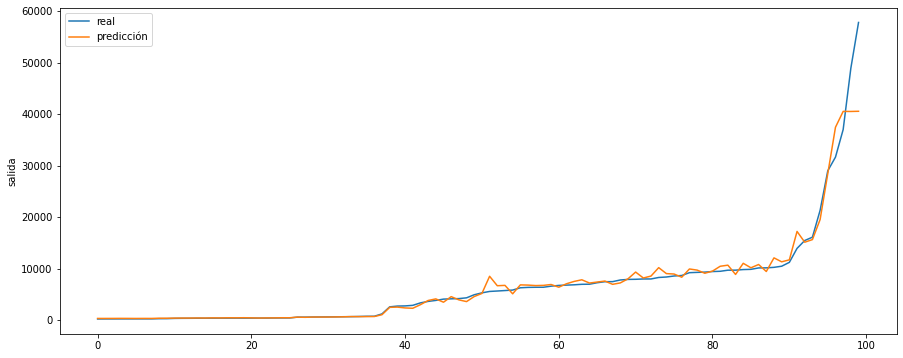

<Figure size 432x288 with 0 Axes>

In [32]:
vtb.visualizar_modelo(model_lstm_sin, x_test_lstm, y_test_lstm)
ftb.guardar_grafico('modelo_lstm_sin.jpg')

### MODELO 4

Probamos después una red neuronal recurrente LSTM con un optimizador adam y dos capas: la primera LSTM de 100 neuronas y la segunda Dense de 50, con dropout. Una capa de salida con una neurona y un entrenamiento de 10 épocas.

La capa Dropout ayuda a evitar el sobreajuste, desactivando neuronas aleatoriamente. 

In [33]:
checkpointer = ModelCheckpoint(filepath=guardar_modelo + "mejores_pesos_lstm_conDO.hdf5", verbose=0, save_best_only=True)
model_lstm_con = Sequential()
model_lstm_con.add(LSTM(100, dropout=0.1, recurrent_dropout=0.1, input_shape=(7, 5)))
model_lstm_con.add(Dropout(0.1))
model_lstm_con.add(Dense(50))
model_lstm_con.add(Dense(1))
model_lstm_con.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
model_lstm_con.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               42400     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 51        
Total params: 47,501
Trainable params: 47,501
Non-trainable params: 0
_________________________________________________________________


In [34]:
start_time = time.time()
for i in range(5):
    print(i)    
    model_lstm_con.fit(x_train_lstm,y_train_lstm,validation_data=(x_test_lstm,y_test_lstm),callbacks=[monitor,checkpointer],verbose=2, epochs=10)
model_lstm_con.load_weights(guardar_modelo + 'mejores_pesos_lstm_conDO.hdf5')

tiempo_procesamiento = time.time() - start_time
print("Tiempo de procesamiento: {}".format(tiempo_procesamiento))

0
Epoch 1/10
62/62 - 4s - loss: 209611344.0000 - val_loss: 186239312.0000
Epoch 2/10
62/62 - 0s - loss: 207295552.0000 - val_loss: 183571824.0000
Epoch 3/10
62/62 - 0s - loss: 203900800.0000 - val_loss: 179938976.0000
Epoch 4/10
62/62 - 0s - loss: 199420320.0000 - val_loss: 175336064.0000
Epoch 5/10
62/62 - 0s - loss: 194118432.0000 - val_loss: 170063936.0000
Epoch 6/10
62/62 - 0s - loss: 188261184.0000 - val_loss: 164494288.0000
Epoch 7/10
62/62 - 0s - loss: 181977392.0000 - val_loss: 158726336.0000
Epoch 8/10
62/62 - 0s - loss: 175717936.0000 - val_loss: 153099344.0000
Epoch 9/10
62/62 - 0s - loss: 169728112.0000 - val_loss: 148023712.0000
Epoch 10/10
62/62 - 0s - loss: 160472672.0000 - val_loss: 137612688.0000
1
Epoch 1/10
62/62 - 0s - loss: 151804768.0000 - val_loss: 130456480.0000
Epoch 2/10
62/62 - 0s - loss: 144167232.0000 - val_loss: 123672344.0000
Epoch 3/10
62/62 - 0s - loss: 136633712.0000 - val_loss: 117322448.0000
Epoch 4/10
62/62 - 0s - loss: 129847616.0000 - val_loss: 11

Visualizamos, a continuación, la gráfica comparativa de los datos reales y de las predicciones a lo largo del tiempo. Y podemos ver que este modelo tiene bastante tasa de acierto. **Consigue un R2 de 0.9268 y un RMSE de 3097.02 aproximadamente**.

Shape: (494, 1)
Puntuación final (RMSE): 3109.1508799136946
Puntuación R cuadrática: 0.926322


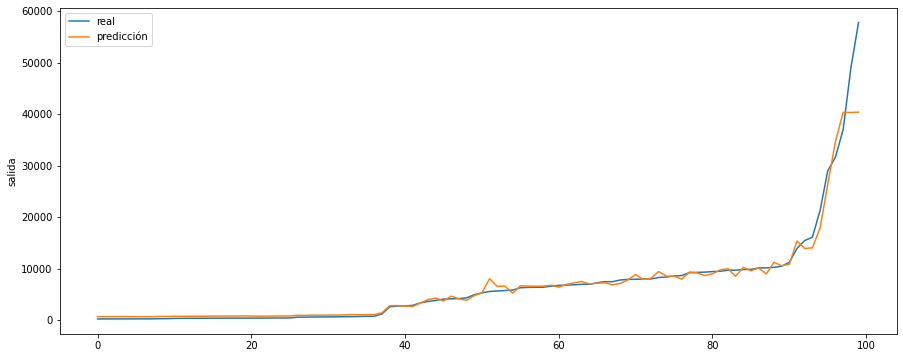

<Figure size 432x288 with 0 Axes>

In [35]:
vtb.visualizar_modelo(model_lstm_con, x_test_lstm, y_test_lstm)
ftb.guardar_grafico('modelo_lstm_con.jpg')

### MODELO 5

Probamos después una red neuronal recurrente LSTM con un optimizador rmsprop y dos capas: la primera LSTM de 100 neuronas y la segunda Dense de 50, con dropout. Una capa de salida con una neurona y un entrenamiento de 10 épocas.

In [36]:
checkpointer = ModelCheckpoint(filepath=guardar_modelo + "mejores_pesos_lstm_rmsprop.hdf5", verbose=0, save_best_only=True)
model_lstm_rmsprop = Sequential()
model_lstm_rmsprop.add(LSTM(100, dropout=0.1, recurrent_dropout=0.1, input_shape=(7, 5)))
model_lstm_rmsprop.add(Dropout(0.1))
model_lstm_rmsprop.add(Dense(50))
model_lstm_rmsprop.add(Dense(1))
model_lstm_rmsprop.compile(loss='mean_squared_error', optimizer='rmsprop')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
model_lstm_rmsprop.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               42400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 51        
Total params: 47,501
Trainable params: 47,501
Non-trainable params: 0
_________________________________________________________________


In [37]:
start_time = time.time()
for i in range(5):
    print(i)    
    model_lstm_rmsprop.fit(x_train_lstm,y_train_lstm,validation_data=(x_test_lstm,y_test_lstm),callbacks=[monitor,checkpointer],verbose=2, epochs=10)
model_lstm_rmsprop.load_weights(guardar_modelo + 'mejores_pesos_lstm_rmsprop.hdf5')

tiempo_procesamiento = time.time() - start_time
print("Tiempo de procesamiento: {}".format(tiempo_procesamiento))

0
Epoch 1/10
62/62 - 4s - loss: 209284416.0000 - val_loss: 186033824.0000
Epoch 2/10
62/62 - 0s - loss: 207425824.0000 - val_loss: 184147792.0000
Epoch 3/10
62/62 - 0s - loss: 205182176.0000 - val_loss: 181809680.0000
Epoch 4/10
62/62 - 0s - loss: 202348160.0000 - val_loss: 178970336.0000
Epoch 5/10
62/62 - 0s - loss: 199094992.0000 - val_loss: 175680352.0000
Epoch 6/10
62/62 - 0s - loss: 195486048.0000 - val_loss: 172223216.0000
Epoch 7/10
62/62 - 0s - loss: 191599584.0000 - val_loss: 168425104.0000
Epoch 8/10
62/62 - 0s - loss: 187238128.0000 - val_loss: 164362464.0000
Epoch 9/10
62/62 - 0s - loss: 182808160.0000 - val_loss: 160287008.0000
Epoch 10/10
62/62 - 0s - loss: 178275952.0000 - val_loss: 156105344.0000
1
Epoch 1/10
62/62 - 0s - loss: 173395200.0000 - val_loss: 150590832.0000
Epoch 2/10
62/62 - 0s - loss: 166783552.0000 - val_loss: 144907984.0000
Epoch 3/10
62/62 - 0s - loss: 160859424.0000 - val_loss: 139860576.0000
Epoch 4/10
62/62 - 0s - loss: 154932416.0000 - val_loss: 13

Visualizamos, a continuación, la gráfica comparativa de los datos reales y de las predicciones a lo largo del tiempo. Y podemos ver que este modelo tiene bastante tasa de acierto. **Consigue un R2 de 0.9131 y un RMSE de 3375.43 aproximadamente**.

Shape: (494, 1)
Puntuación final (RMSE): 3496.2019310093688
Puntuación R cuadrática: 0.906836


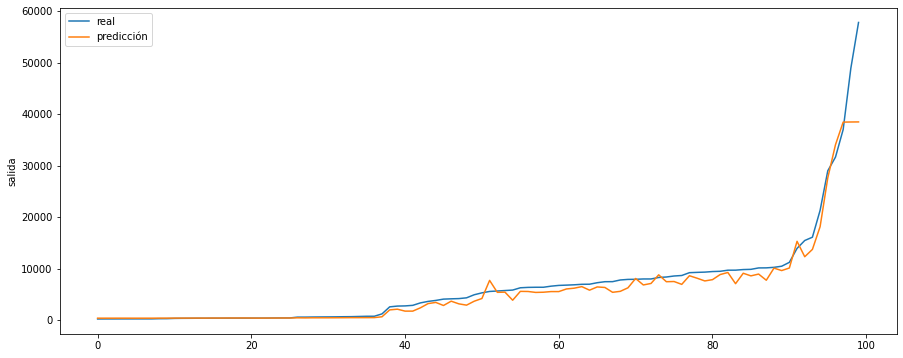

<Figure size 432x288 with 0 Axes>

In [38]:
vtb.visualizar_modelo(model_lstm_rmsprop, x_test_lstm, y_test_lstm)
ftb.guardar_grafico('modelo_lstm_rmsprop.jpg')

### MODELO 6

Probamos después una red neuronal recurrente LSTM con un optimizador rmsprop y dos capas: la primera LSTM de 500 neuronas y la segunda Dense de 50, con dropout. Una capa de salida con una neurona y un entrenamiento de 10 épocas.

In [39]:
checkpointer = ModelCheckpoint(filepath=guardar_modelo + "mejores_pesos_lstm_rmsprop500.hdf5", verbose=0, save_best_only=True)
model_lstm_rmsprop500 = Sequential()
model_lstm_rmsprop500.add(LSTM(500, dropout=0.1, recurrent_dropout=0.1, input_shape=(7, 5)))
model_lstm_rmsprop500.add(Dropout(0.1))
model_lstm_rmsprop500.add(Dense(50))
model_lstm_rmsprop500.add(Dense(1))
model_lstm_rmsprop500.compile(loss='mean_squared_error', optimizer='rmsprop')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
model_lstm_rmsprop500.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 500)               1012000   
_________________________________________________________________
dropout_2 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 50)                25050     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 51        
Total params: 1,037,101
Trainable params: 1,037,101
Non-trainable params: 0
_________________________________________________________________


In [40]:
start_time = time.time()
for i in range(5):
    print(i)    
    model_lstm_rmsprop500.fit(x_train_lstm,y_train_lstm,validation_data=(x_test_lstm,y_test_lstm),callbacks=[monitor,checkpointer],verbose=2, epochs=10)
model_lstm_rmsprop500.load_weights(guardar_modelo + 'mejores_pesos_lstm_rmsprop500.hdf5')

tiempo_procesamiento = time.time() - start_time
print("Tiempo de procesamiento: {}".format(tiempo_procesamiento))

0
Epoch 1/10
62/62 - 8s - loss: 205739200.0000 - val_loss: 179805904.0000
Epoch 2/10
62/62 - 5s - loss: 197369216.0000 - val_loss: 171233600.0000
Epoch 3/10
62/62 - 5s - loss: 187518256.0000 - val_loss: 161604560.0000
Epoch 4/10
62/62 - 4s - loss: 176812000.0000 - val_loss: 152093552.0000
Epoch 5/10
62/62 - 5s - loss: 165223840.0000 - val_loss: 138776560.0000
Epoch 6/10
62/62 - 4s - loss: 156593072.0000 - val_loss: 127182656.0000
Epoch 7/10
62/62 - 4s - loss: 137295680.0000 - val_loss: 116565888.0000
Epoch 8/10
62/62 - 4s - loss: 125609752.0000 - val_loss: 105608160.0000
Epoch 9/10
62/62 - 5s - loss: 119729264.0000 - val_loss: 97860304.0000
Epoch 10/10
62/62 - 5s - loss: 106132760.0000 - val_loss: 88639808.0000
1
Epoch 1/10
62/62 - 5s - loss: 94993936.0000 - val_loss: 81043624.0000
Epoch 2/10
62/62 - 5s - loss: 85873656.0000 - val_loss: 71782920.0000
Epoch 3/10
62/62 - 5s - loss: 75669096.0000 - val_loss: 64008412.0000
Epoch 4/10
62/62 - 5s - loss: 65661820.0000 - val_loss: 54482816.00

Visualizamos, a continuación, la gráfica comparativa de los datos reales y de las predicciones a lo largo del tiempo. Y podemos ver que este modelo tiene bastante tasa de acierto. **Consigue un R2 de 0.9909 y un RMSE de 1092.61 aproximadamente**.

Shape: (494, 1)
Puntuación final (RMSE): 1102.6516259429222
Puntuación R cuadrática: 0.990733


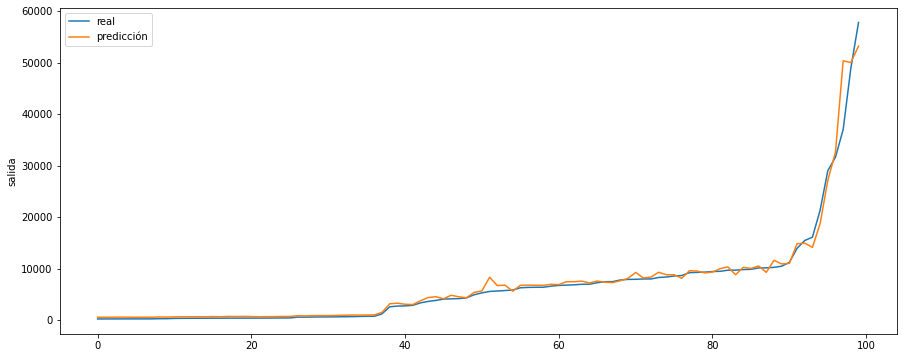

<Figure size 432x288 with 0 Axes>

In [41]:
vtb.visualizar_modelo(model_lstm_rmsprop500, x_test_lstm, y_test_lstm)
ftb.guardar_grafico('modelo_lstm_rmsprop500.jpg')

## Conclusiones y experiencia personal

Como podemos observar, el **Modelo 1** es el que mejor resultados nos da. Hay que entender que para entrenar estas redes neuronales, sólo se han tenido en cuenta valores númericos básicos de una acción; pero en la variación de precios actúan, como ya se explicó al inicio, más factores difícilmente cuantificables y predecibles.

Este proyecto me ha costado muchísimo, ya que he tenido grandes dificultades para entender la materia por la abstracción de los conceptos y la matemática que hay detrás.

Si tuviera que hacer el proyecto de nuevo, me gustaría hacerlo de algo más visual; pero teniendo una buena base de entendimiento de los algoritmos de ML.

De ahora en adelante, intentaré formarme más a conciencia en esta materia, yendo a un ritmo algo más lento pero más seguro.

Igualmente, la experiencia ha sido muy agradable para mí ya que me gustan los retos.

También añadir, que esta vez quise exponer mi proyecto de una forma algo más interactiva que con Prezi. Fabricando yo mi propio programa con la ayuda de OpenCv. También supuso un reto esto para mí.

## Tiempo del proyecto

In [3]:
tiempo_proyecto = pd.read_csv(os.path.dirname(os.getcwd()) + SEP + 'resources' + SEP + 'data' + SEP + 'tiempos.csv')

In [4]:
tiempo_proyecto

Tarea  Tiempo total
0  Data searching and wranling             1
1         Select model and try            19
2  Preparing and training data            96
3                Visualization             2
4                    Dashboard             8
5              Creating an API             2
6   Preparing the presentation            40

In [5]:
print('Horas dedicadas al proyecto:',tiempo_proyecto['Tiempo total'].sum())

Horas dedicadas al proyecto: 168


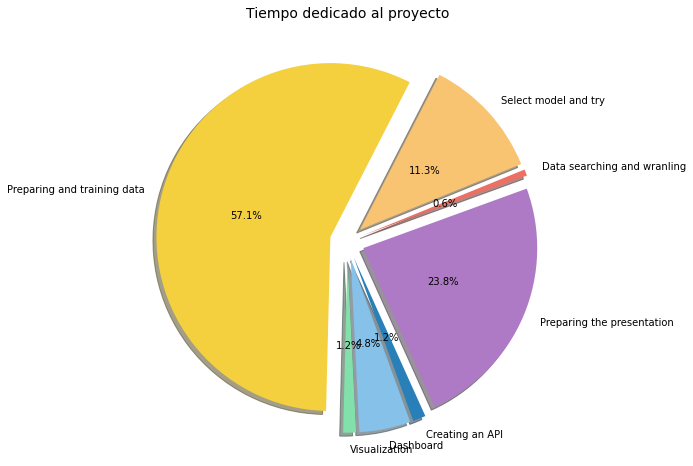

In [6]:
pie, ax = plt.subplots(figsize=[10,8])
colors = ['#EC7063', '#F8C471', '#F4D03F', '#82E0AA', '#85C1E9', '#2980B9', '#AF7AC5']
plt.title("Tiempo dedicado al proyecto", fontsize=14)
plt.pie(
    x=tiempo_proyecto['Tiempo total'], 
    autopct="%.1f%%", 
    explode=[0.1]*7, 
    labels=tiempo_proyecto['Tarea'], 
    pctdistance=0.5, 
    shadow=True, 
    startangle=20, 
    colors=colors
);